In [183]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.optimize as so

class Camera(object):
    def __init__(self):
        self.p = None                   # Pose
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # Sensor
        
        
    def rotational_transform(self,pts,pose):
            """  
            This function performs the translation and rotation from world coordinates into generalized camera coordinates.
            This function takes the Easting, Northing, and Elevation of the features in an image.
            The pose vector is unknown and what we are looking to optimize.
            """
            cam_x = pose[0]
            cam_y = pose[1]
            cam_z = pose[2]
            roll = pose[3]
            pitch = pose[4]
            yaw = pose[5]

            r_axis = np.array([[1, 0, 0], 
                               [0, 0,-1], 
                               [0, 1, 0]])
            
            r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], 
                               [0, 1, 0], 
                               [np.sin(roll), 0, np.cos(roll)]])
            
            r_pitch = np.array([[1, 0, 0], 
                                [0, np.cos(pitch), np.sin(pitch)], 
                                [0, -1*np.sin(pitch), np.cos(pitch)]])
            
            r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], 
                              [np.sin(yaw), np.cos(yaw), 0, 0], 
                              [0, 0, 1, 0]])

            T = np.array([[1, 0, 0, -cam_x], 
                          [0, 1, 0, -cam_y], 
                          [0, 0, 1, -cam_z], 
                          [0, 0, 0, 1]])

            C = r_axis @ r_roll @ r_pitch @ r_yaw @ T

            return C @ pts
        
        
    def projective_transform(self,rot_pt):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        This function needs the outputs of the rotational transform function (the rotated points).
        """
        focal = self.f 
        sensor = self.c 
        
        rot_pt = rot_pt.T
        
        #General Coordinates
        gcx = rot_pt[:,0]/rot_pt[:,2]
        gcy = rot_pt[:,1]/rot_pt[:,2]
        
        #Pixel Locations
        pu = gcx*focal + sensor[0]/2.
        pv = gcy*focal + sensor[1]/2.
        
        return np.array([pu,pv]).T
      
    
    def residual(self, pose, pts, u_gcp):
        ''' Calculate the residual between transformed coordinates on prominant features and measured pixel values of those features'''
        pt = myCam.projective_transform(myCam.rotational_transform(pts,pose))
        res = pt.flatten() - u_gcp.flatten()
        return res
    
    def estimate_pose(self, pts, u_gcp):
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """
        p_opt = so.least_squares(self.residual, self.p, method='lm',args=(pts,u_gcp))
        
        return p_opt

In [184]:
# Coordinates (UTM and elation) for the features found in the image.
gcps = []
f = open('image_coordinates.txt', 'r')
for line in f:
    line = line.replace("\n", "")
    line = line.split(',')
    gcps.append(line)    
gcps = np.array(gcps)[:,:5].astype(float)
pts = gcps[:,2:5]
pts = (np.c_[pts, np.ones(pts.shape[0])]).T

# Pixel coordinates of the features in the 2D image
u_gcp = gcps[:,0:2]

In [185]:
# Initial guess at pose
roll_init = np.radians(0.0)
pitch_init = np.radians(0.0)
yaw_init = np.radians(90.0)
pose_0 = np.array([3.229e5, 4.306e6, 1, roll_init, pitch_init, yaw_init])

# Initialize camera object
myCam = Camera()
myCam.f = (28/36.)*4032. # Focal length
myCam.c = np.array([4032.,3024.]) # Sensor size
myCam.p = pose_0

pose = myCam.estimate_pose(pts, u_gcp)

In [186]:
# Estimated pose of the Camera

print ('\n%.0f E'%(pose.x[0]))
print ('%.0f N'%(pose.x[1]))
print ('%.0f meters elevation'%(pose.x[2]))
print ('%.2f Roll'%(pose.x[3]))
print ('%.2f Pitch'%(pose.x[4]))
print ('%.2f Yaw'%(pose.x[5]))

print ('\n18 S %.2f %.2f'%(pose.x[0],pose.x[1]))


322968 E
4306489 N
13 meters elevation
0.11 Roll
0.04 Pitch
1.53 Yaw

18 S 322967.71 4306488.76


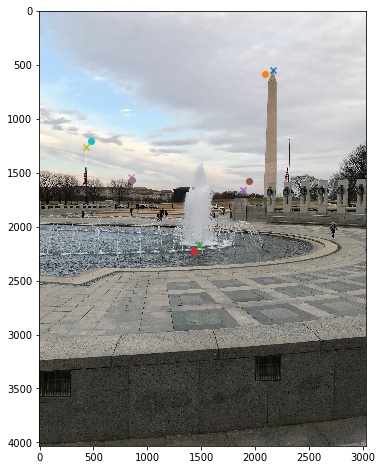

In [187]:
# Generalized coordinates with optimal pose
gcpr_opt = myCam.rotational_transform(pts,pose.x)
gcp_opt = myCam.projective_transform(gcpr_opt)

fig,ax = plt.subplots(figsize=(10,8))
for x in range(len(gcp_opt)):
    plt.scatter(u_gcp[x][0], u_gcp[x][1], marker='x')
    plt.scatter(gcp_opt[x][0], gcp_opt[x][1])
im = plt.imread('national_mall.jpg')
implot = plt.imshow(im)

In [188]:
######
#Test on Campus example problem
#####

In [189]:
# Coordinates (UTM and elation) for the features found in the image.
gcps = []
f = open('image_coordinates_campus.txt', 'r')
for line in f:
    # Remove newline characters
    line = line.replace("\n", "")
    # Delimit by comma
    line = line.split('|')
    gcps.append(line)    
gcps = np.array(gcps)[:,:5].astype(float)
pts = gcps[:,2:5]
pts = (np.c_[pts, np.ones(pts.shape[0])]).T 


# Pixel coordinates of the features in the 2D image
u_gcp = gcps[:,0:2]
#print (u_gcp.shape)

In [190]:
roll_init = np.radians(0.0)
pitch_init = np.radians(0.0)
yaw_init = np.radians(90.0)
pose_0 = np.array([2.72e5, 5.193e6, 1000, roll_init, pitch_init, yaw_init])

myCam = Camera()
myCam.f = (27/36)*3264 # Focal length
myCam.c = np.array([2448.,3264.]) # Sensor size
myCam.p = pose_0

pose = myCam.estimate_pose(pts, u_gcp)

In [191]:
# Estimated pose of the Camera
print ('\n%.0f E'%(pose.x[0]))
print ('%.0f N'%(pose.x[1]))
print ('%.0f meters elevation'%(pose.x[2]))
print ('%.2f Roll'%(pose.x[3]))
print ('%.2f Pitch'%(pose.x[4]))
print ('%.2f Yaw'%(pose.x[5]))


print ('\n12 T %.2f %.2f'%(pose.x[0],pose.x[1]))


272469 E
5193991 N
986 meters elevation
-0.00 Roll
0.04 Pitch
1.81 Yaw

12 T 272469.01 5193991.44


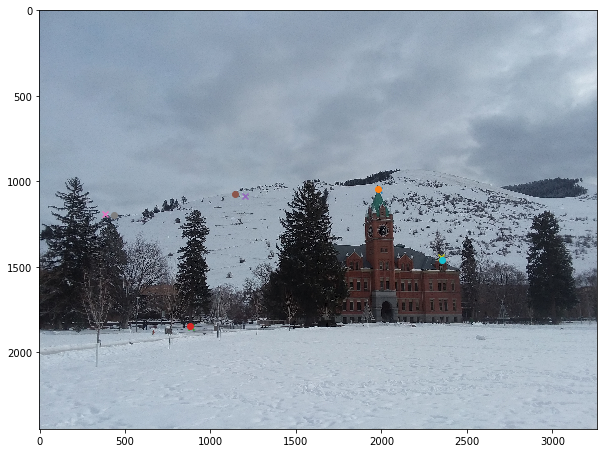

In [192]:
# Generalized coordinates with optimal pose
gcpr_opt = myCam.rotational_transform(pts,pose.x)
gcp_opt = myCam.projective_transform(gcpr_opt)

fig,ax = plt.subplots(figsize=(10,8))
for x in range(len(gcp_opt)):
    plt.scatter(u_gcp[x][0], u_gcp[x][1], marker='x')
    plt.scatter(gcp_opt[x][0], gcp_opt[x][1])
im = plt.imread('campus.jpg')
implot = plt.imshow(im)